In [17]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
os.environ["TRANSFORMERS_CACHE"]="/workspace/cache"
os.environ["HF_DATASETS_CACHE"]="/workspace/cache"
import datasets
from datasets import load_dataset
from sentence_transformers import SentenceTransformer

import os
import requests
from tqdm import tqdm
import pickle 
from PIL import Image
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import requests
import pandas as pd
import torch

In [18]:
model = SentenceTransformer("sentence-transformers/clip-ViT-B-32").to('cuda')

# Load Dataset

## Load Ref datasets

In [19]:
sea_vqa_images_filt, sea_vqa_images_embed, sea_vqa_caption, sea_vqa_culture = pickle.load(open('sea_vqa.pkl', 'rb'))
cvqa_images_filt, cvqa_images_embed, cvqa_caption, cvqa_culture = pickle.load(open('cvqa.pkl', 'rb'))

ref_images_filt = sea_vqa_images_filt + cvqa_images_filt
ref_images_embed = sea_vqa_images_embed + cvqa_images_embed
ref_vqa_caption = sea_vqa_caption + cvqa_caption
ref_vqa_culture = sea_vqa_culture + cvqa_culture

## Load Ref cat dataset

In [20]:
refcat_images_embed, refcat_caption, refcat_culture, refcat_category = pickle.load(open('cvqa_category_all.pkl', 'rb'))

In [21]:
refcat_embed_np = np.stack(refcat_images_embed, axis=0)
refcat_category_np = np.array(refcat_category)

categories = [
    'Geography / buildings / landmarks','Brands / products / companies', 'Vehicles and Transportation',
    'Cooking and food', 'Objects / materials / clothing', 'People and everyday life', 'Plants and animal',
    'Public Figure and pop culture', 'Traditions / art / history', 'Sports and recreation'
]
category_embs = []
for cat in categories:
    category_embs.append(torch.from_numpy(refcat_embed_np[refcat_category_np == cat]).mean(dim=0))
category_embs = torch.stack(category_embs, axis=0)

## Load target filtering dataset

In [22]:
coyo_images_filt, coyo_images_embed, coyo_caption, _ = pickle.load(open('./coyo.pkl', 'rb'))

# Image Similarity

In [23]:
coyo_ref_scores = model.similarity(ref_images_embed, coyo_images_embed)
coyo_cat_scores = model.similarity(category_embs, coyo_images_embed)

## SEA-VQA Sample

******* Reference-0 *******
=== Candidate #0 ===
Reference Caption: Which aspect of Cambodian culture is heavily illustrated in this ancient artifact? Celebratory and martial traditions
Candidate Caption: Rock Relief at Yeh Pulu. Photo by Namhar
Culture: cambodia
Score:0.8496274948120117


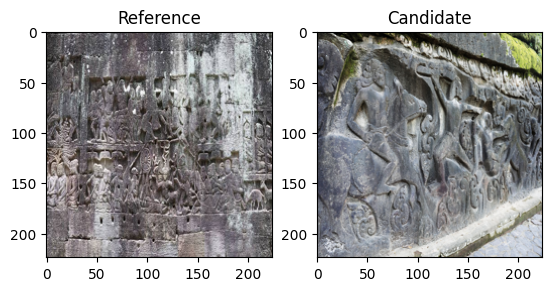

****************************************************************************************************
******* Reference-3 *******
=== Candidate #0 ===
Reference Caption: To what era does this bas-relief belong? 12th-13th century
Candidate Caption: Rock Relief at Yeh Pulu. Photo by Namhar
Culture: cambodia
Score:0.8413801193237305


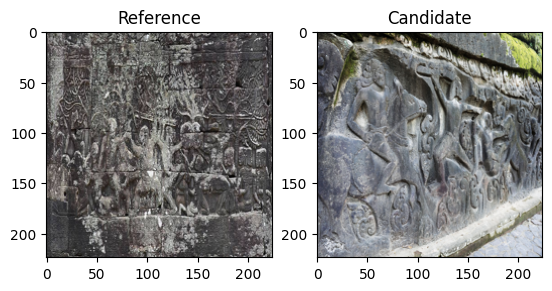

****************************************************************************************************
******* Reference-9 *******
=== Candidate #0 ===
Reference Caption: What could the different colors seen in the decorations signify in Cambodian culture? Representations of different spiritual realms
Candidate Caption: Top 4 Beautiful Villages in Hoi An Country Side
Culture: cambodia
Score:0.8271137475967407


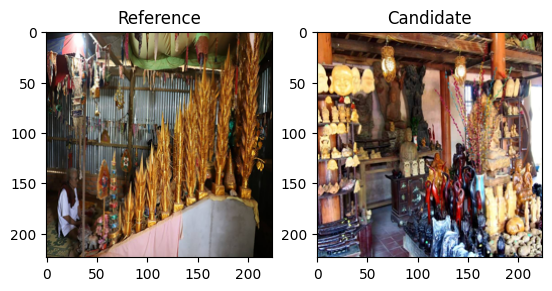

****************************************************************************************************
******* Reference-11 *******
=== Candidate #0 ===
Reference Caption: The facial expressions combined with the gestures in dance primarily aim to: Portray joy and festivity
Candidate Caption: Cơ Tu people offer traditions to tourists
Culture: cambodia
Score:0.8626490235328674


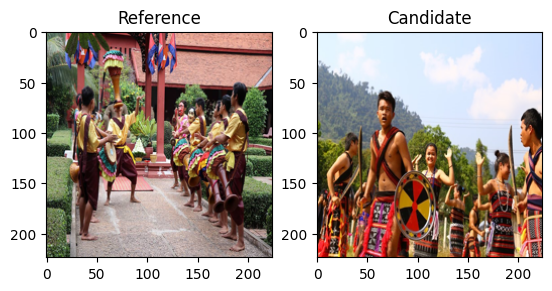

****************************************************************************************************
******* Reference-12 *******
=== Candidate #0 ===
Reference Caption: What is the most probable time of day for this martial arts demonstration based on the lighting and shadows in the image? Midday
Candidate Caption: This mother won’t let conflict tear families apart
Culture: cambodia
Score:0.8202131986618042


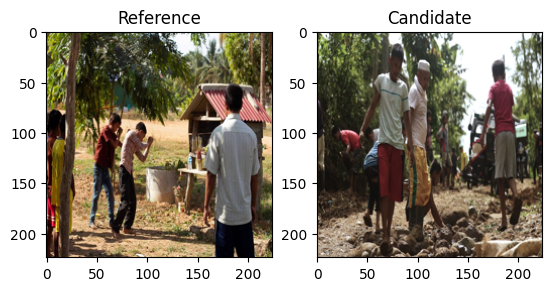

****************************************************************************************************
******* Reference-17 *******
=== Candidate #0 ===
Reference Caption: What notable feature of the event is specifically tied to Cambodian cultural practices? The use of mats for the performance
Candidate Caption: Men arrested for stealing from rescuers of drowning students in central Vietnam
Culture: cambodia
Score:0.8128255605697632


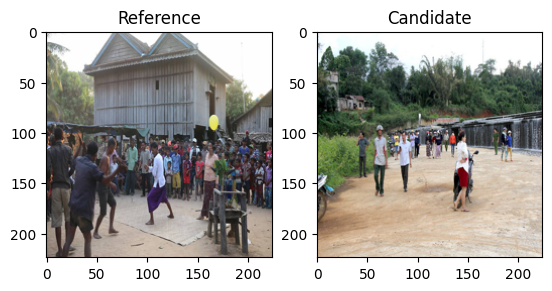

****************************************************************************************************


In [24]:
top_k=1
last_embed = None
for idx in range(20):
    if last_embed is None:
        last_embed = ref_images_embed[idx]
    elif (last_embed == ref_images_embed[idx]).all():
        continue
    elif (last_embed != ref_images_embed[idx]).all():
        last_embed = ref_images_embed[idx]

    sorted_index = np.argsort(np.array(coyo_ref_scores[idx]))[::-1]
    image = ref_images_filt[idx]
    caption = ref_vqa_caption[idx]
    culture = ref_vqa_culture[idx]

    print(f"******* Reference-{idx} *******")
    for rank, cand_idx in enumerate(sorted_index[:top_k]):
        print(f"=== Candidate #{rank} ===")
        print(f"Reference Caption: {caption}")
        print(f"Candidate Caption: {coyo_caption[cand_idx]}")
        print(f"Culture: {culture}")
        print(f"Score:{coyo_ref_scores[idx][cand_idx]}")

        fig, (ax1, ax2) = plt.subplots(1, 2)

        # Display the first PIL Image in the left subplot
        ax1.imshow(image.resize((224, 224), Image.BICUBIC))
        ax1.set_title('Reference')

        # Display the second PIL Image in the right subplot
        try:
            ax2.imshow(Image.open(requests.get(coyo_images_filt[cand_idx], stream=True).raw).resize((224, 224), Image.BICUBIC))
        except:
            pass
        ax2.set_title('Candidate')
        plt.show()
    print("*"*100)

## mean vector

******* Mean Reference *******
=== Candidate #0 ===
Candidate Caption: Thanh Ha Pottery village
Score:0.6066116094589233
Category:People and everyday life


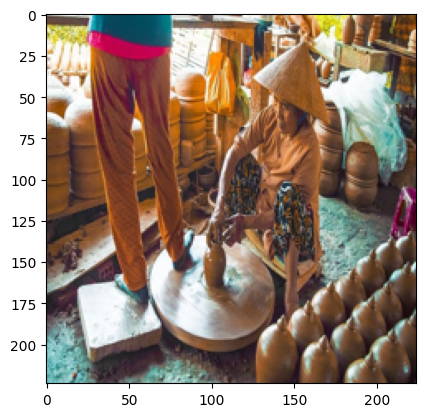

=== Candidate #1 ===
Candidate Caption: A Hmong food stall at Dak R’Mang Market in Dak Nong Province. Photo: Dinh Cuong / Tuoi Tre
Score:0.6042618155479431
Category:People and everyday life


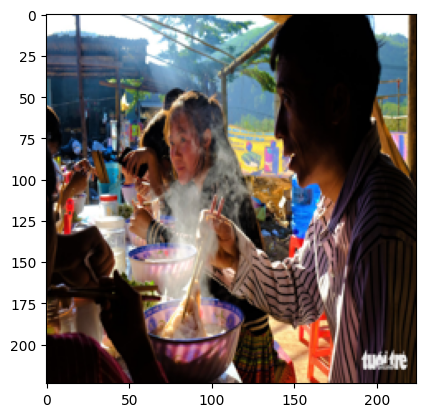

=== Candidate #2 ===
Candidate Caption: Discover Sin Ho market - Experience when traveling to Sin Ho plateau
Score:0.6020543575286865
Category:People and everyday life


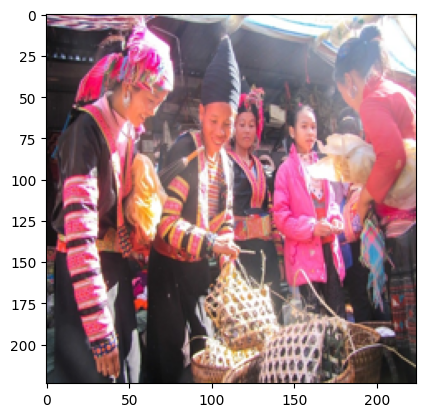

=== Candidate #3 ===
Candidate Caption: late night wedding a unique custom of yao ethnic community in vietnam
Score:0.5980937480926514
Category:People and everyday life


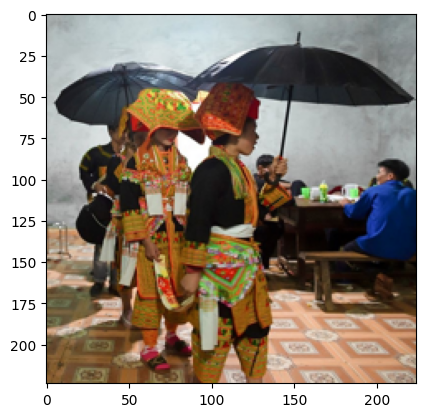

=== Candidate #4 ===
Candidate Caption: Ron nguoi tap tuc “song” cung nguoi chet cua bo toc o Malaysia-Hinh-4
Score:0.5979475378990173
Category:Traditions / art / history


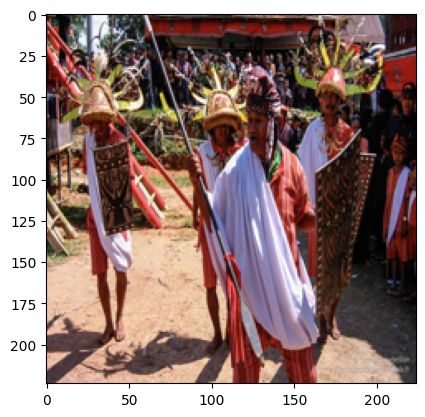

=== Candidate #5 ===
Candidate Caption: Tran Thi Dang and her two sons gather around for a simple meal.
Score:0.5976319313049316
Category:People and everyday life


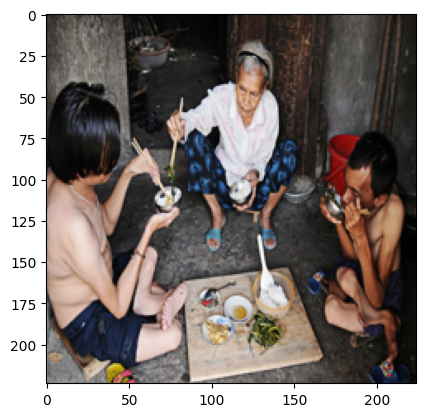

=== Candidate #6 ===
Candidate Caption: PAGCOR announces 24 grand winners in its 4th National Photo Contest
Score:0.5959935188293457
Category:People and everyday life


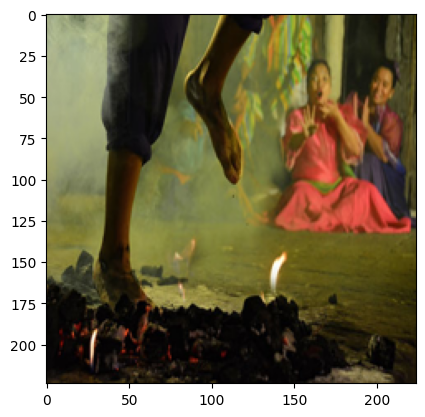

=== Candidate #7 ===
Candidate Caption: Vietnamese ethnic village set to host Great National Unity Week
Score:0.5958899855613708
Category:Traditions / art / history
=== Candidate #8 ===
Candidate Caption: City districts support new rural areas
Score:0.5958249568939209
Category:People and everyday life


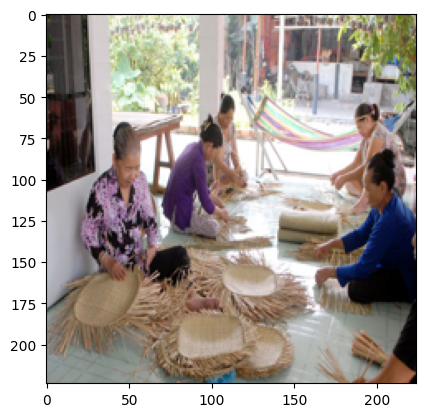

=== Candidate #9 ===
Candidate Caption: Students engrossed in reading, Panyaden Reading Day 2017
Score:0.5950269103050232
Category:People and everyday life


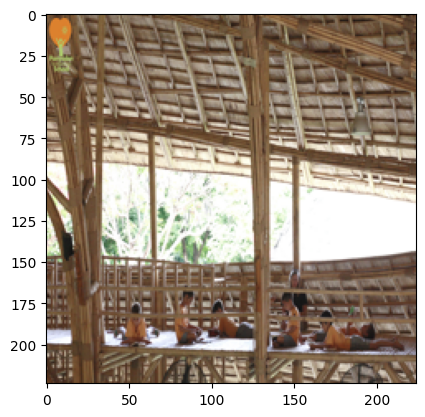

=== Candidate #10 ===
Candidate Caption: Students engrossed in reading, Panyaden Reading Day 2017
Score:0.5950269103050232
Category:People and everyday life


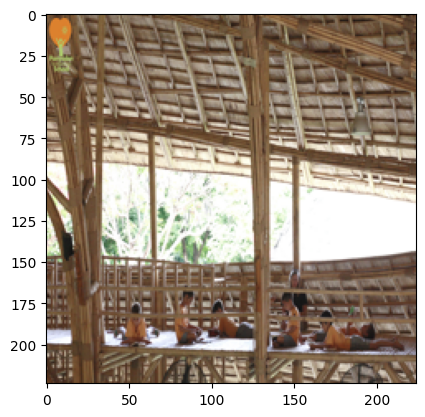

=== Candidate #11 ===
Candidate Caption: In Penang, Thnee Kong’s birthday is observed with much pomp and pride.
Score:0.5944597721099854
Category:People and everyday life


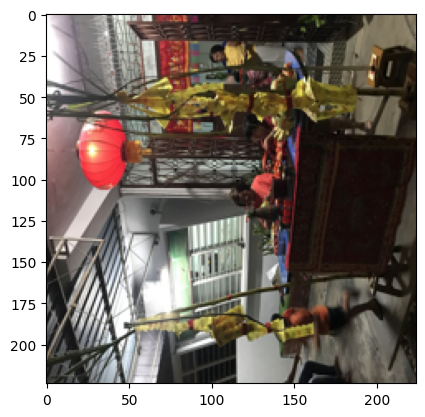

=== Candidate #12 ===
Candidate Caption: A dancer takes charge of drumming during a performance. Photo: Tuoi Tre
Score:0.5944013595581055
Category:Traditions / art / history


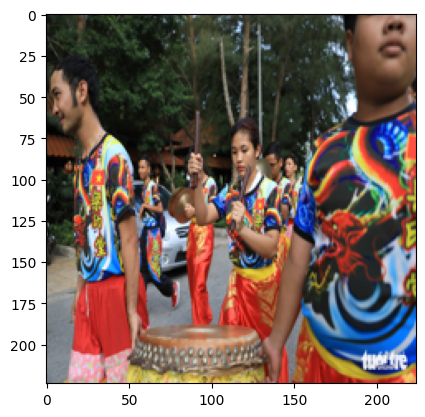

=== Candidate #13 ===
Candidate Caption: the closest airport to Hoi An
Score:0.5943260788917542
Category:People and everyday life


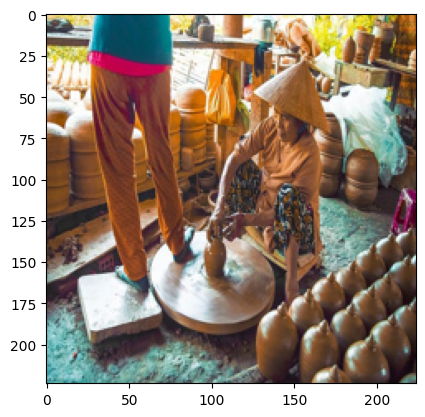

=== Candidate #14 ===
Candidate Caption: Covid-19 Spread Out: Nunas Ica Peneduh Gumi Ceremony is Held by Bali Indigenous Village Residents
Score:0.5941748023033142
Category:Traditions / art / history


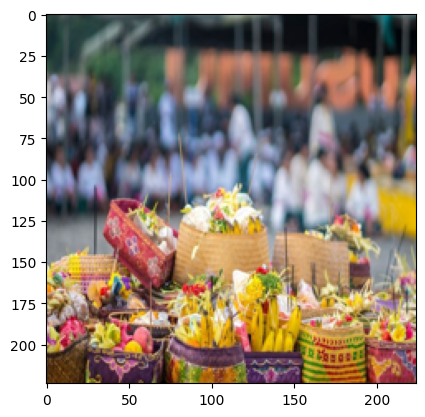

=== Candidate #15 ===
Candidate Caption: For observers, treat this ceremony with respect. Don't get too close with your 30MP selfie phone! Image from Vietnamitas En Madrid.
Score:0.5940638184547424
Category:People and everyday life


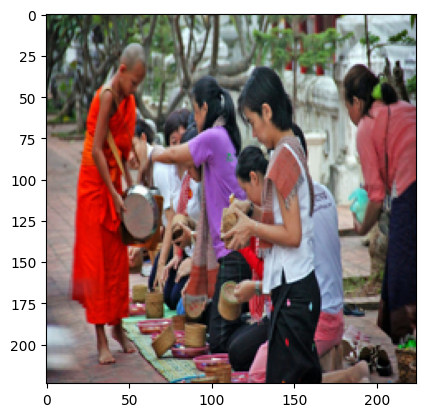

=== Candidate #16 ===
Candidate Caption: Covid-19 hotspot returns to bustling life as over month-long lockdown ends
Score:0.5939639210700989
Category:People and everyday life


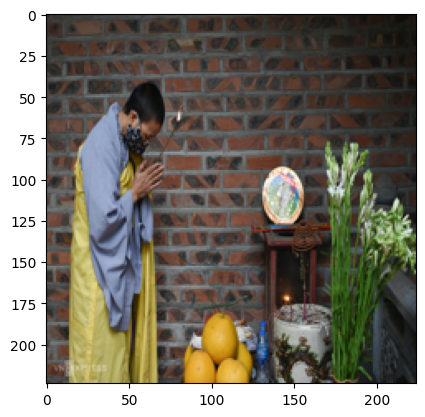

=== Candidate #17 ===
Candidate Caption: More opportunities for youth to volunteer overseas
Score:0.5938069224357605
Category:People and everyday life


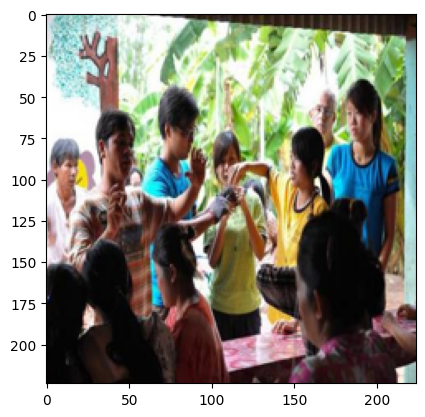

=== Candidate #18 ===
Candidate Caption: shorten and simplify hung kings festival due to fears of coronavirus
Score:0.5934610962867737
Category:Traditions / art / history


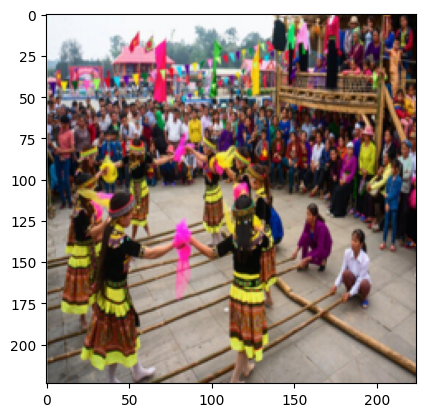

=== Candidate #19 ===
Candidate Caption: Famous incense-making village in Hue turns colorful as Tet nears
Score:0.5934488773345947
Category:People and everyday life


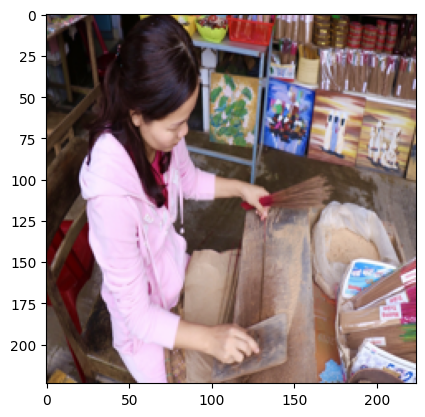

****************************************************************************************************


In [25]:
top_k=20
last_embed = None

mean_ref_score = coyo_ref_scores.mean(dim=0)
sorted_index = np.argsort(np.array(mean_ref_score))[::-1]

print(f"******* Mean Reference *******")
for rank, cand_idx in enumerate(sorted_index[:top_k]):
    try:
        print(f"=== Candidate #{rank} ===")
        print(f"Candidate Caption: {coyo_caption[cand_idx]}")
        print(f"Score:{mean_ref_score[cand_idx]}")
        print(f"Category:{categories[int(coyo_cat_scores[:,cand_idx].argmax())]}")

        plt.imshow(Image.open(requests.get(coyo_images_filt[cand_idx], stream=True).raw).resize((224, 224), Image.BICUBIC))
        plt.show()
    except:
        pass
print("*"*100)

tensor(0.5833)


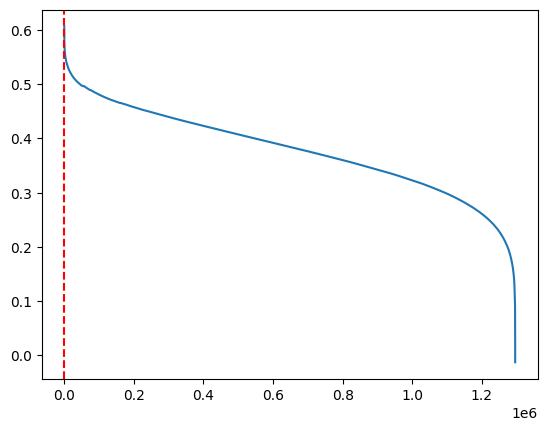

In [26]:
import seaborn as sns
ax = plt.plot(mean_ref_score.sort(descending=True).values)
print(mean_ref_score.sort(descending=True).values[100])
plt.axvline(x=200, ymin=0, ymax=1.0, linestyle='--', color='r')
plt.show()

# use the above value as similarity treshold (we need 1% pass similar to CC3M)

In [49]:
threshold_value = 0.565

In [50]:
print(f'# accepted samples: {int((mean_ref_score >= threshold_value).sum())}')
print(f'% accepted samples: {float((mean_ref_score >= threshold_value).sum() / mean_ref_score.shape[0])*100:.2f}%')

# accepted samples: 956
% accepted samples: 0.07%


In [ ]:
data = {'img_url': [], 'caption': [], 'category': [], 'match_score': []}
for cand_idx, pass_threshold in enumerate((mean_ref_score >= threshold_value).tolist()):
    if pass_threshold:
        img_url = coyo_images_filt[cand_idx]
        caption = coyo_caption[cand_idx]
        category = categories[int(coyo_cat_scores[:,cand_idx].argmax())]
        match_score = mean_ref_score[cand_idx]
        
        data['img_url'].append(img_url)
        data['caption'].append(caption)
        data['category'].append(category)
        data['match_score'].append(match_score)
pd.DataFrame(data).to_csv('output/coyo.csv', index=False)